<a href="https://colab.research.google.com/github/rpatel71/Design-Optimization/blob/main/Project_1/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import logging
import torch as t
import math
import time
from torch.nn import utils
import torch.nn as nn
from torch import optim 
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.01 # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
THRUST_ACCEL = 600  # thrust constant
ANG_THRUST = 400  # Angular Thrust Constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = ((THRUST_ACCEL * FRAME_TIME * t.tensor([0., 0.,-1., 0., 0., 0.]) * action[0])
                     + (THRUST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1., 0., 0.]) * action[1])
                     + ( ANG_THRUST  * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * action[2]))

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., 0., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., FRAME_TIME, 0., 0.],
                             [0., 0., 1., 0., 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [12]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            # You can add more layers here
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output)
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [30., 20., 20., 30., 25, 50]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        err = state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2 + state[5]**2
        return err

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        ang_disp = data[:, 4]
        ang_vel = data[:, 5]
        ft = range(self.simulation.T)

        fig, ax = plt.subplots(1, 3, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'C0', label = "Coordinates")
        ax[0].set_xlabel("X-coordinates (m)")
        ax[0].set_ylabel("Y-coordinates (m)")
        ax[0].legend(frameon=0)
        ax[0].set(title='Displacement plot')

        ax[1].plot(ft, vx, c = 'b', label = "Velocity in x")
        ax[1].plot(ft, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time interval (1 s)")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title ='Velocity plot')

        ax[2].plot(ft, ang_disp, c = 'b', label = "Angluar Displacement")
        ax[2].plot(ft, ang_vel, c = 'r', label = "Angular Velocity")
        ax[2].set_xlabel("Time interval (1 s)")
        ax[2].set_ylabel("Angular Displacment (deg) and Velocity (deg/s)")
        ax[2].legend(frameon=0)
        ax[2].set(title='Angular Displacement and Velocity plot')

        plt.show()

[1] loss: 32808.035


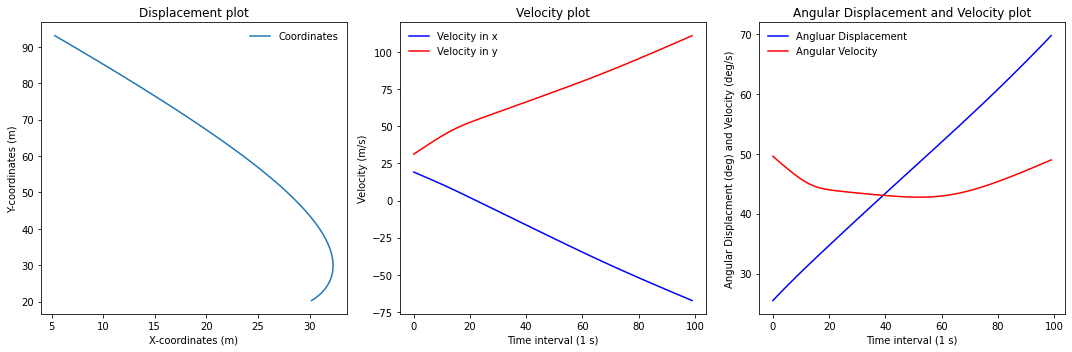

[2] loss: 16455.322


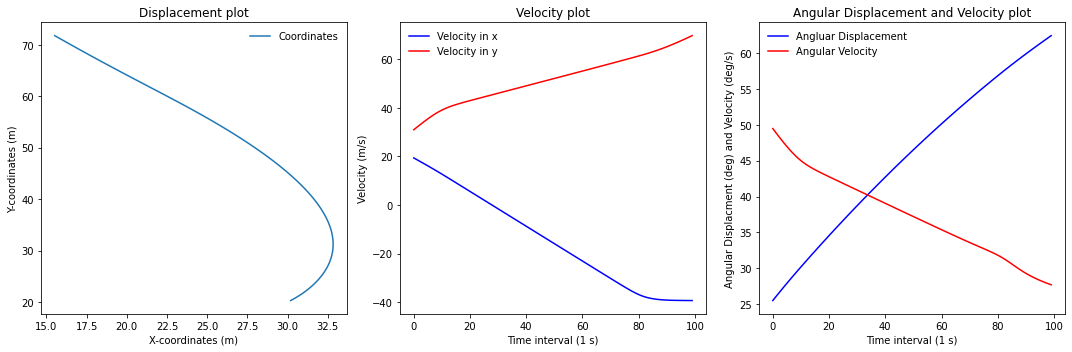

[3] loss: 12440.939


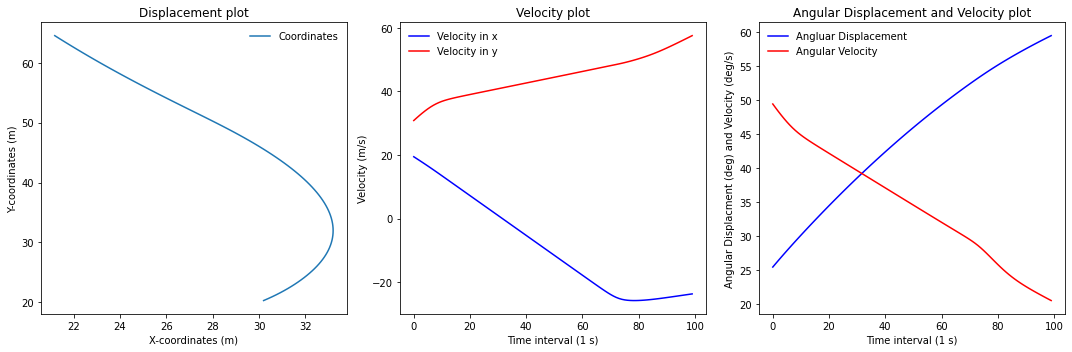

[4] loss: 8991.114


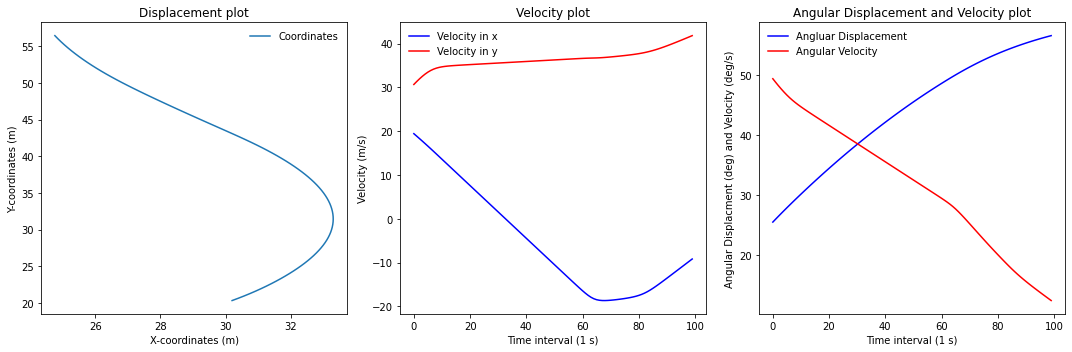

[5] loss: 6482.980


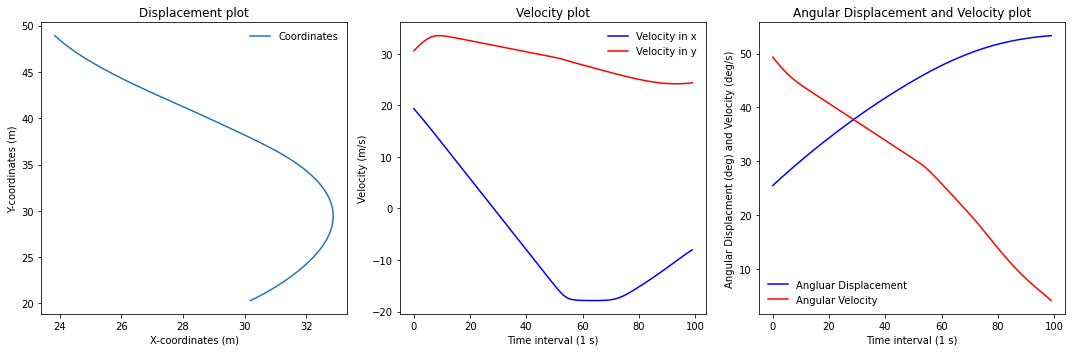

[6] loss: 5646.436


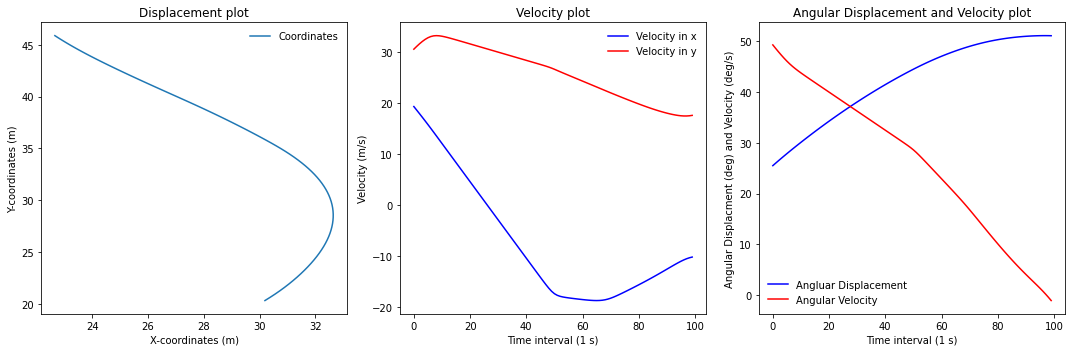

[7] loss: 5062.614


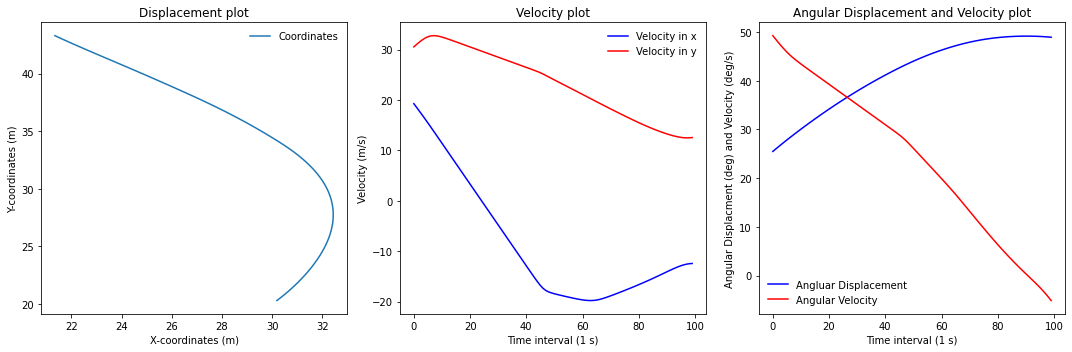

[8] loss: 4636.327


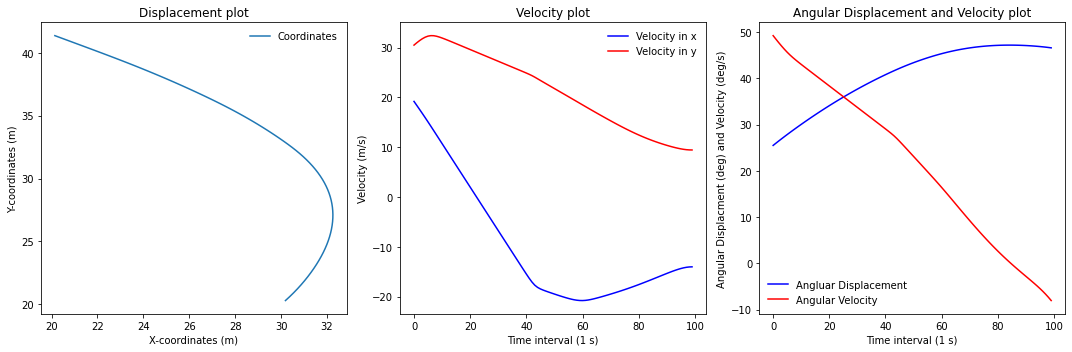

[9] loss: 4229.529


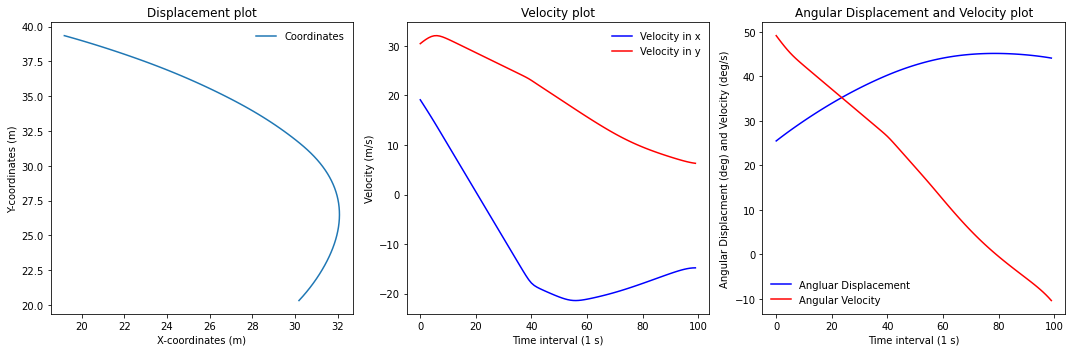

[10] loss: 3792.995


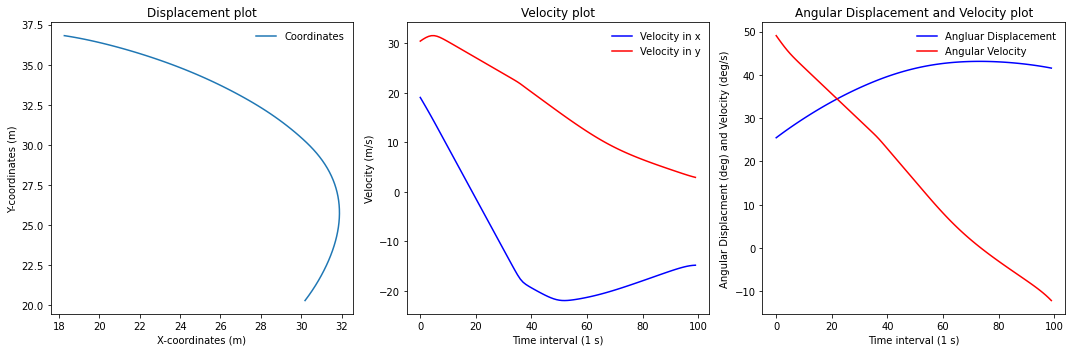

[11] loss: 3122.878


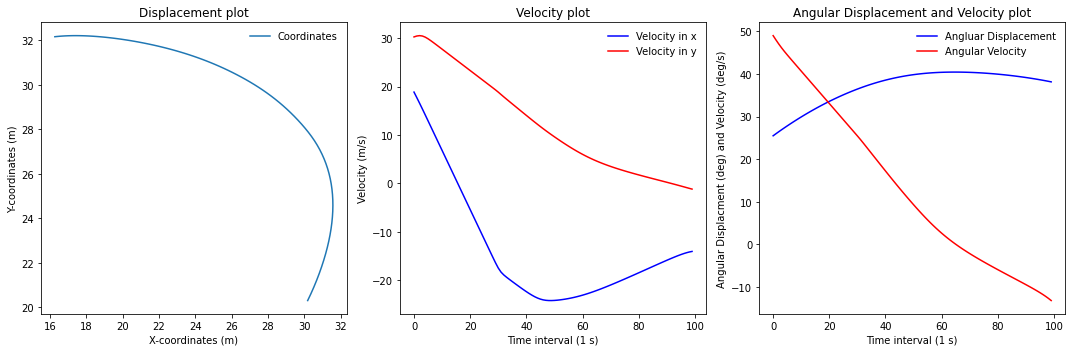

[12] loss: 1827.736


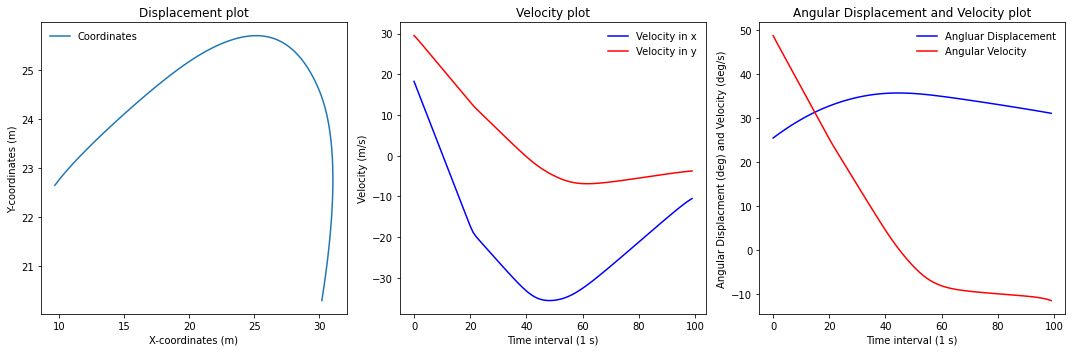

[13] loss: 1001.353


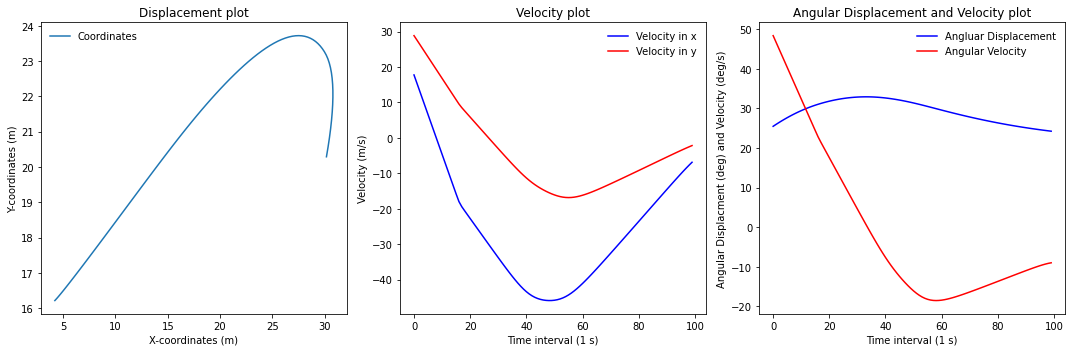

[14] loss: 675.041


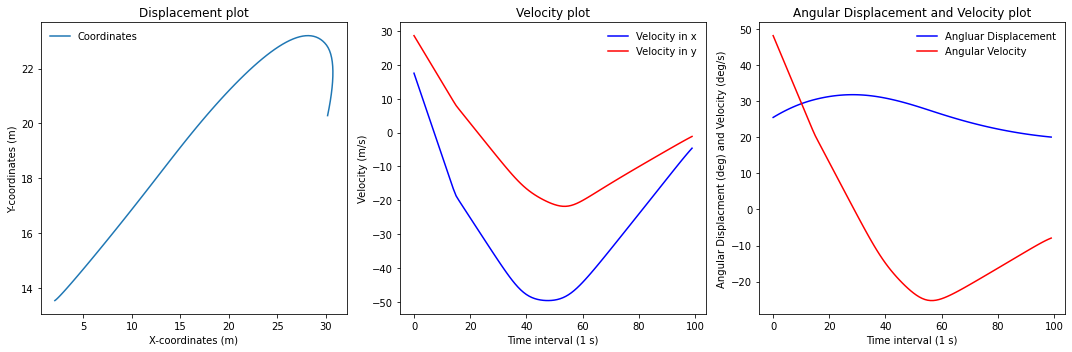

[15] loss: 468.344


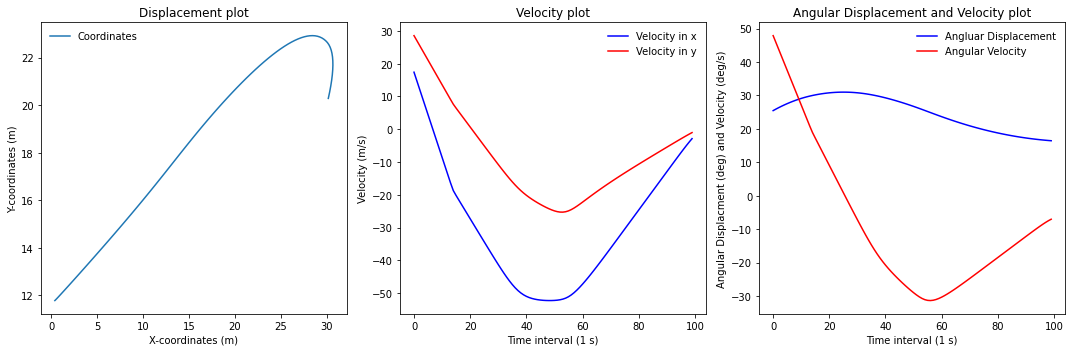

[16] loss: 359.191


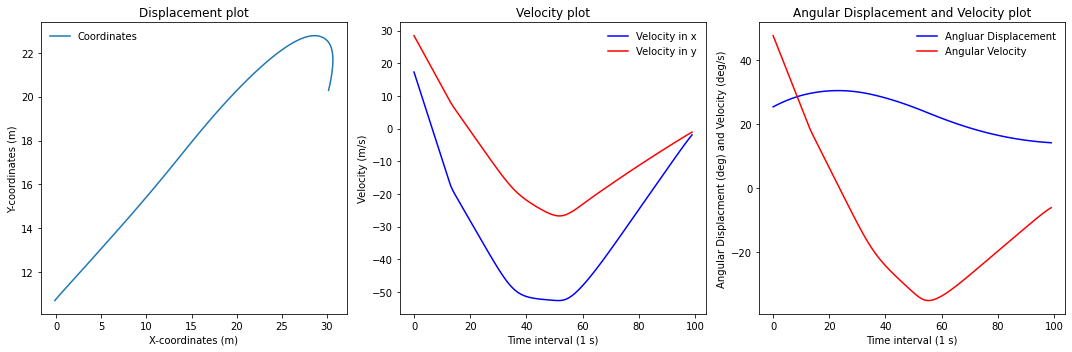

[17] loss: 268.841


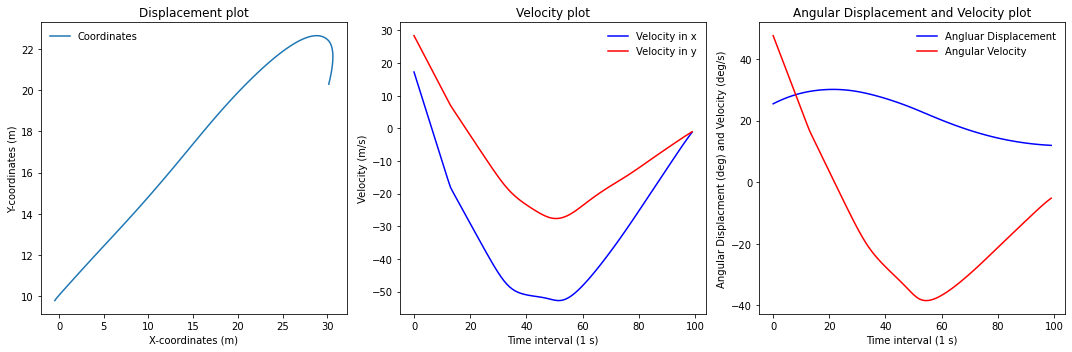

[18] loss: 188.032


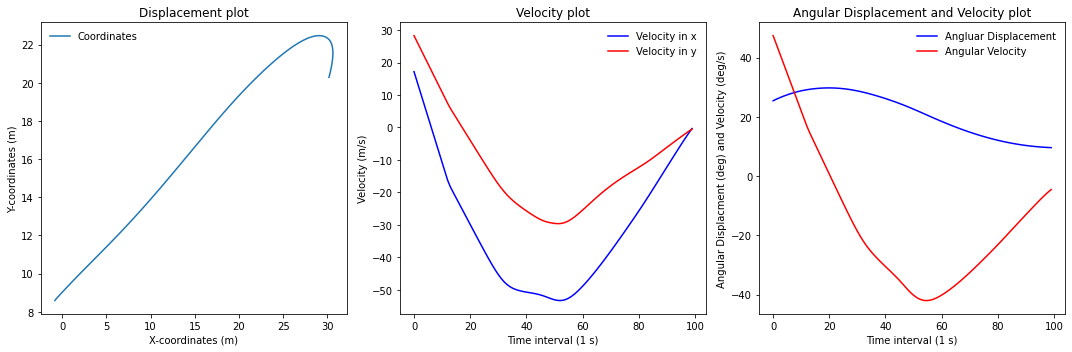

[19] loss: 121.686


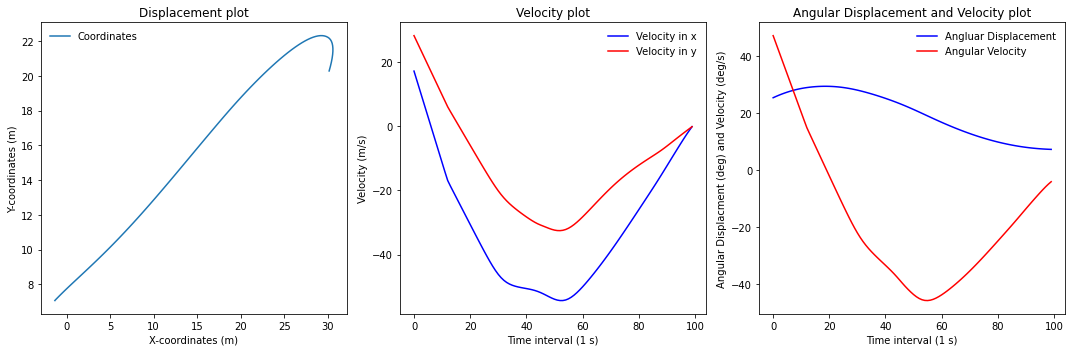

[20] loss: 82.173


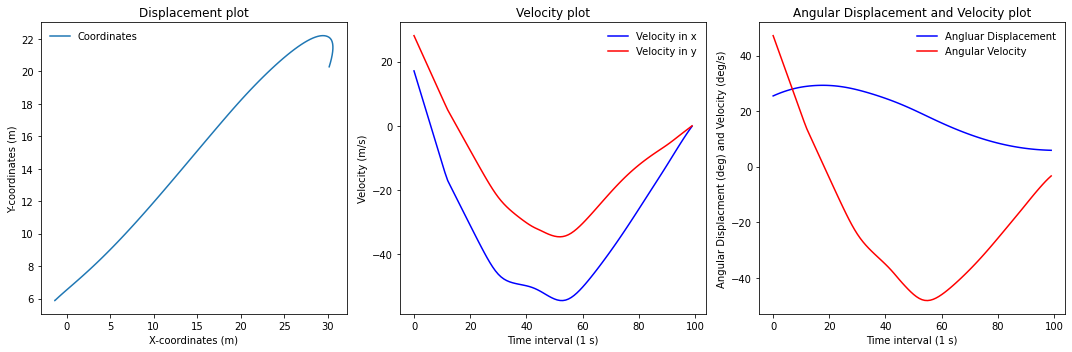

[21] loss: 58.491


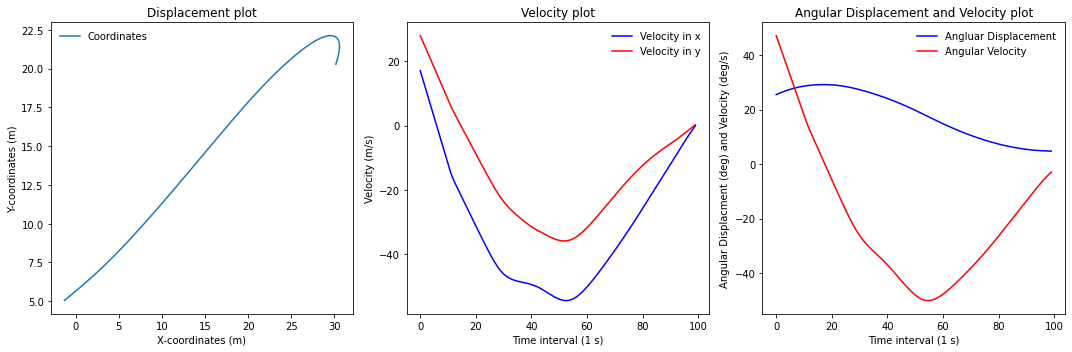

[22] loss: 42.673


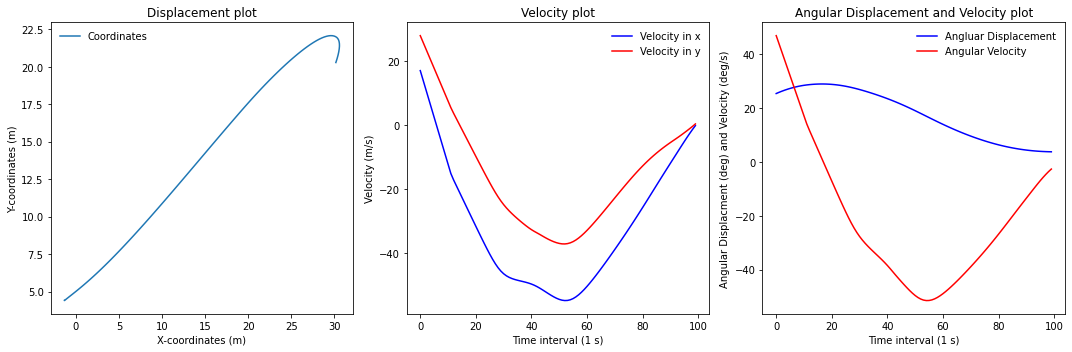

[23] loss: 31.883


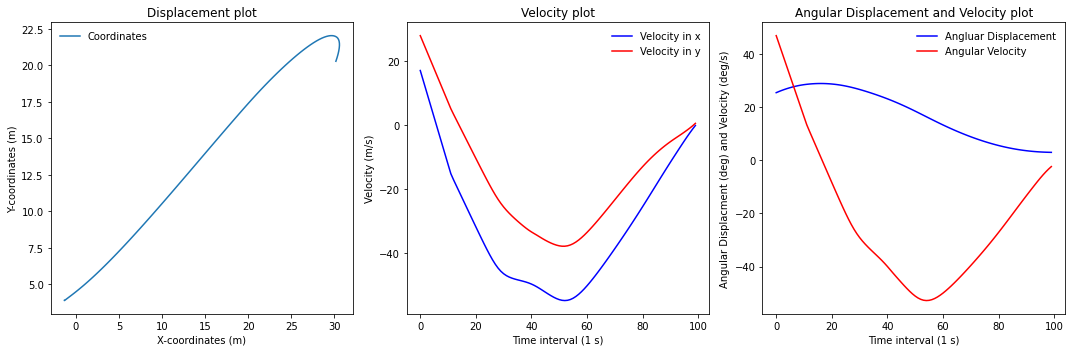

[24] loss: 23.991


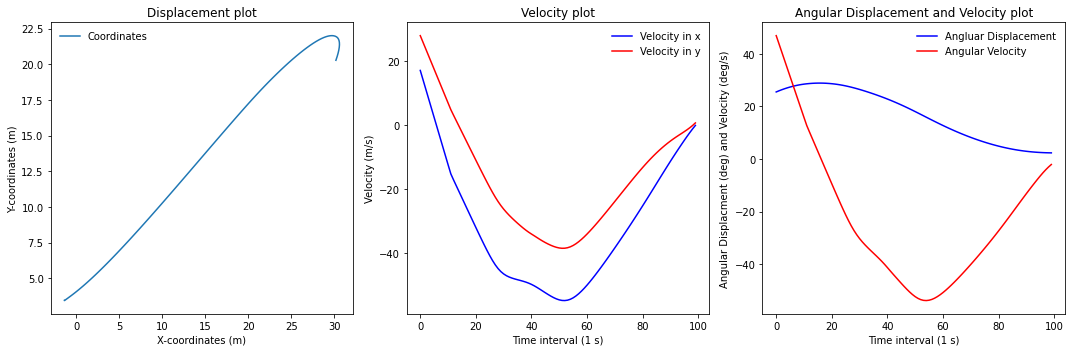

[25] loss: 18.298


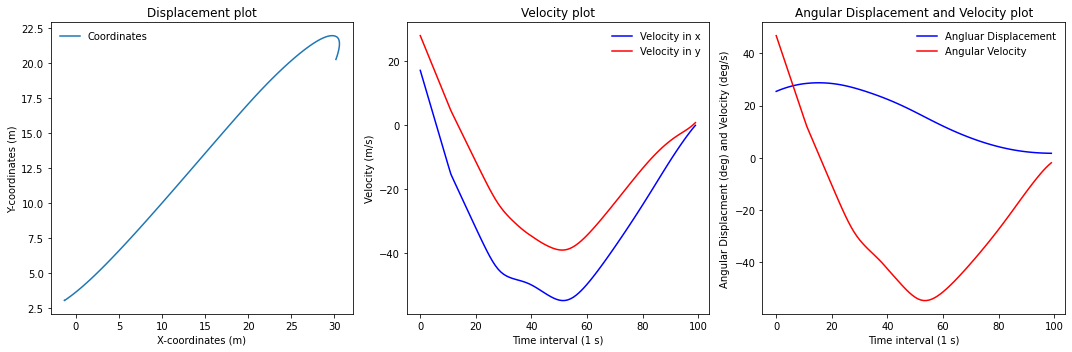

[26] loss: 14.210


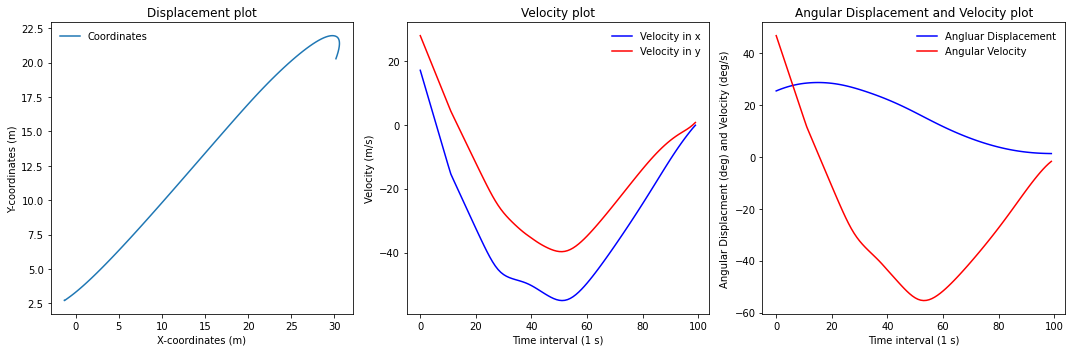

[27] loss: 11.202


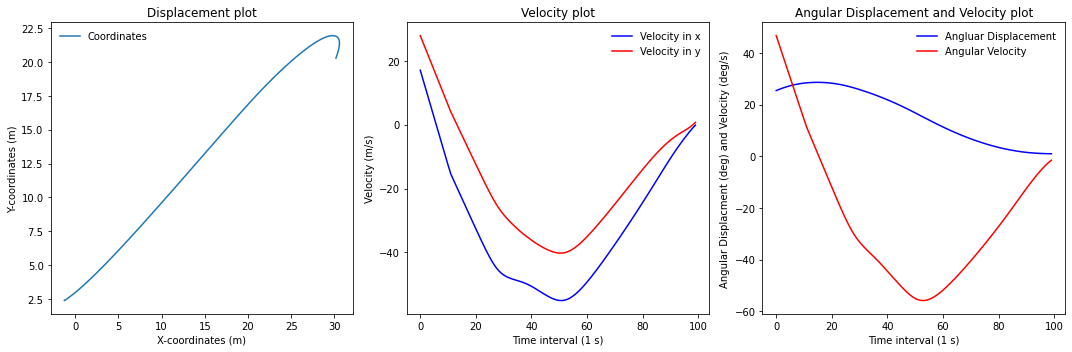

[28] loss: 8.960


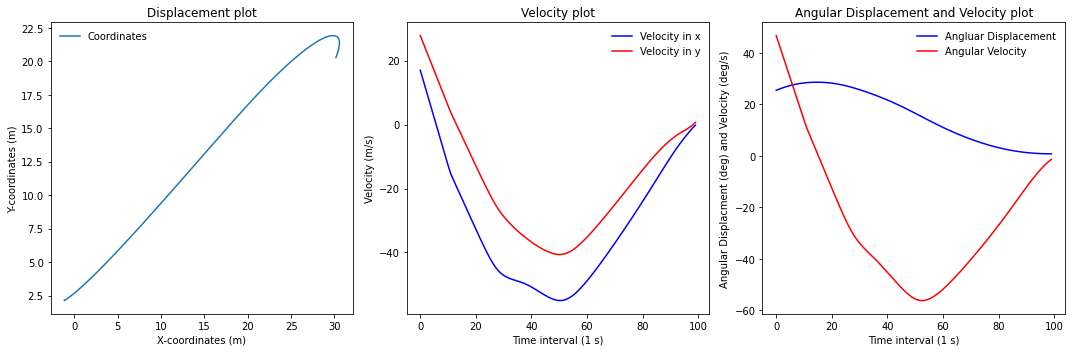

[29] loss: 7.143


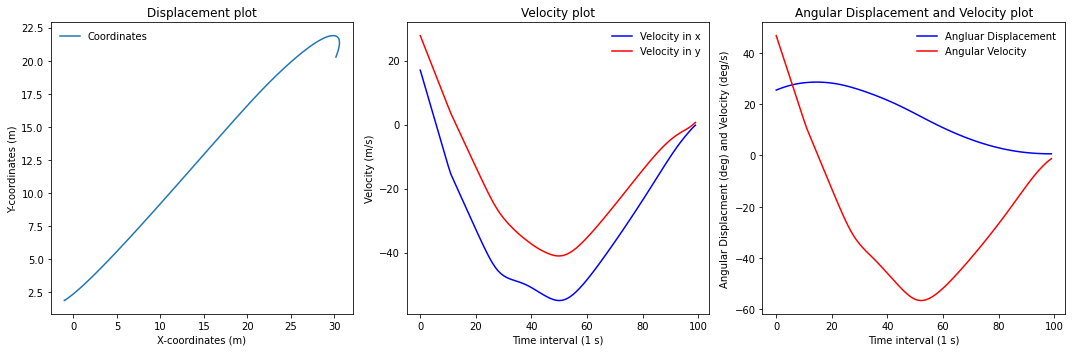

[30] loss: 5.720


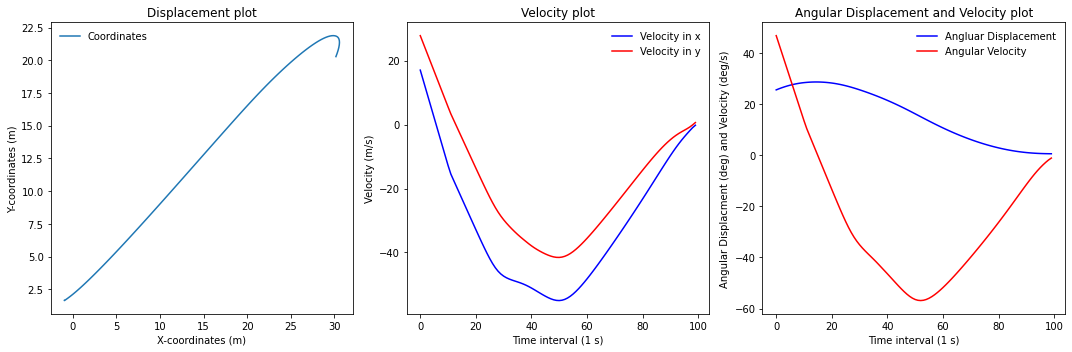

[31] loss: 4.620


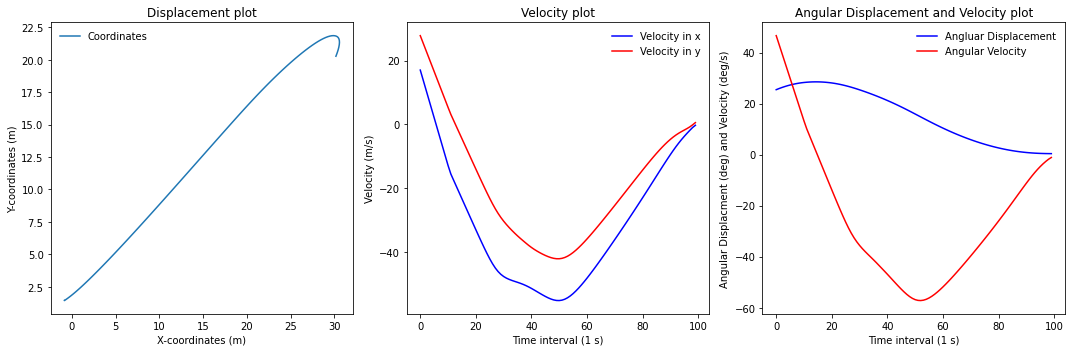

[32] loss: 3.768


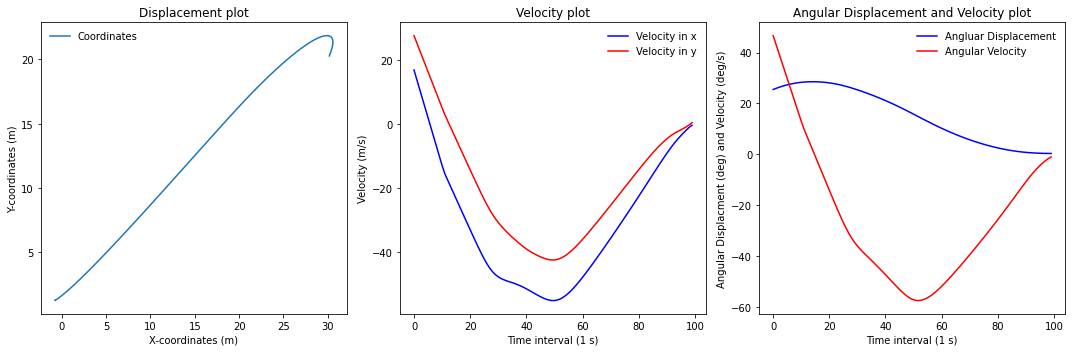

[33] loss: 3.107


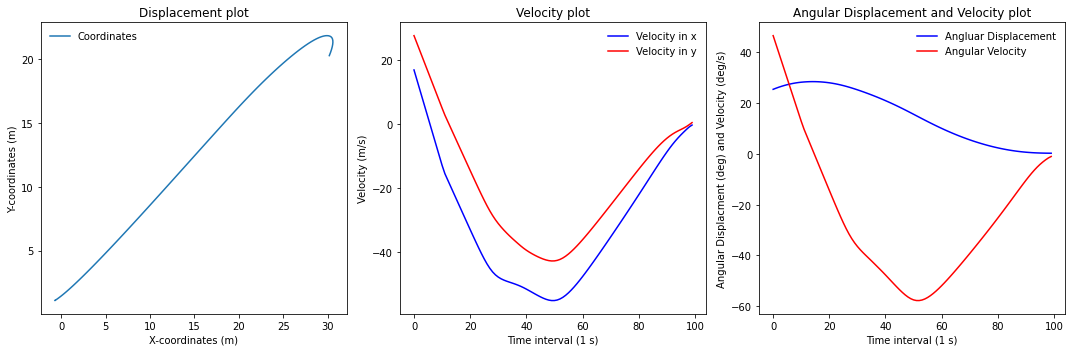

[34] loss: 2.597


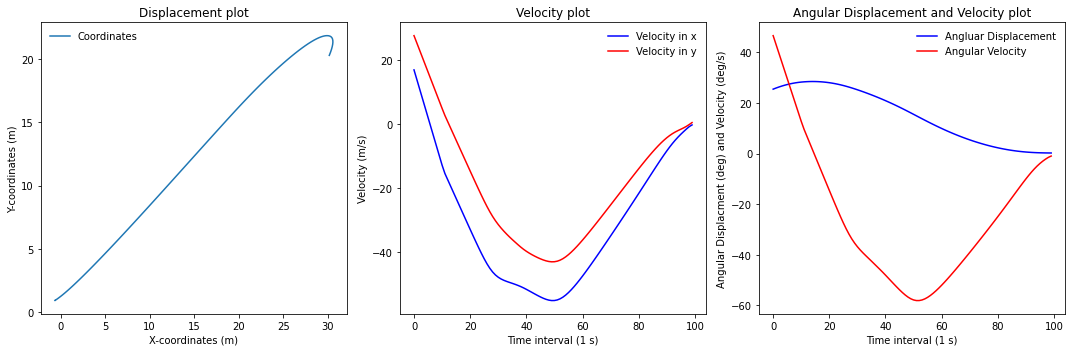

[35] loss: 2.189


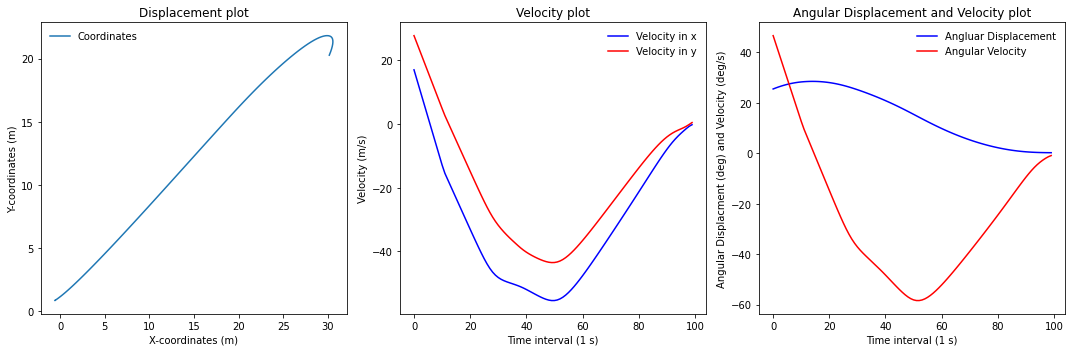

[36] loss: 1.870


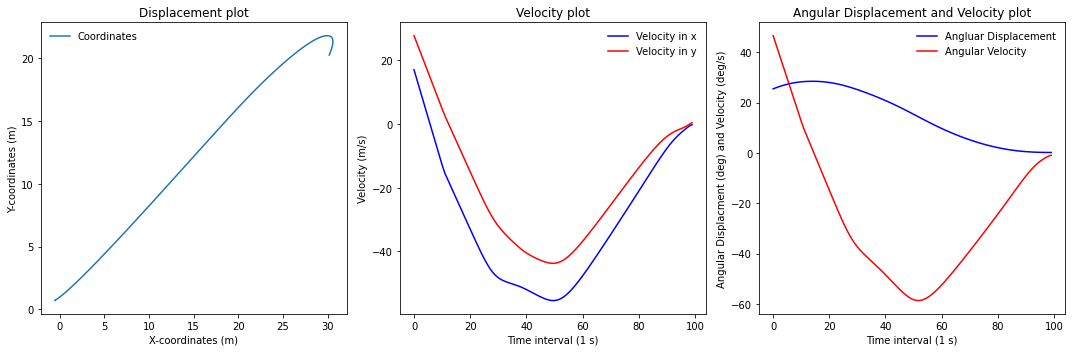

[37] loss: 1.603


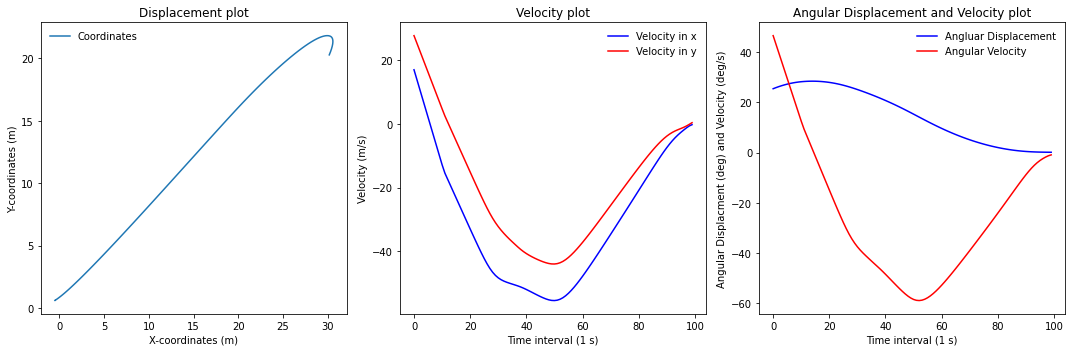

[38] loss: 1.379


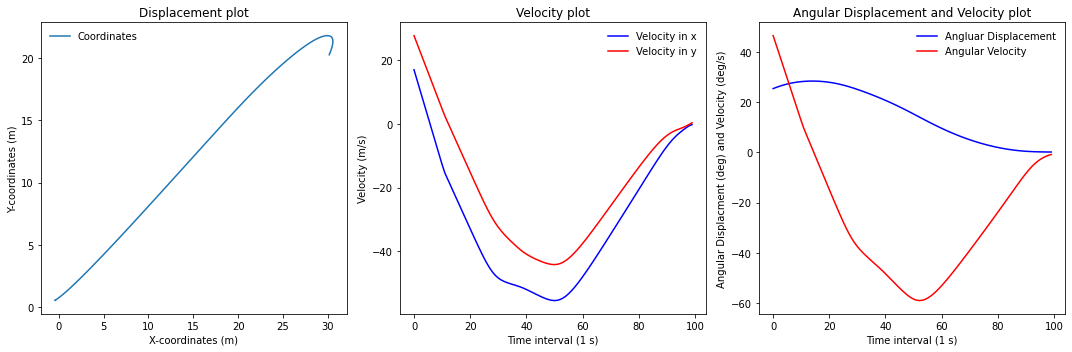

[39] loss: 1.199


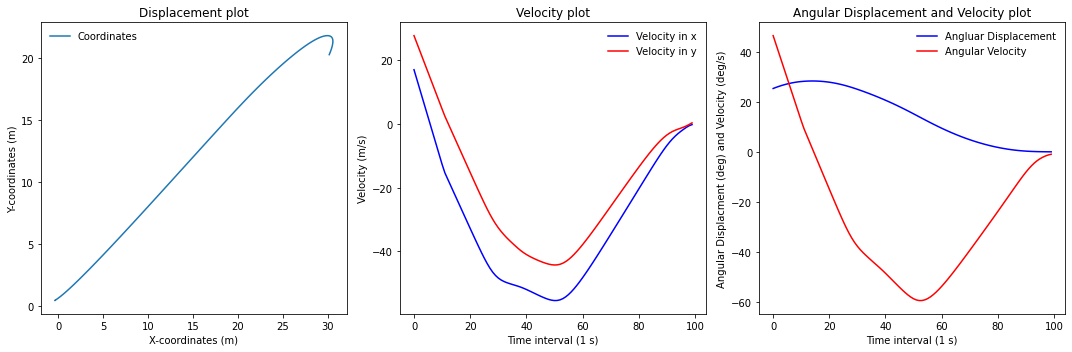

[40] loss: 1.028


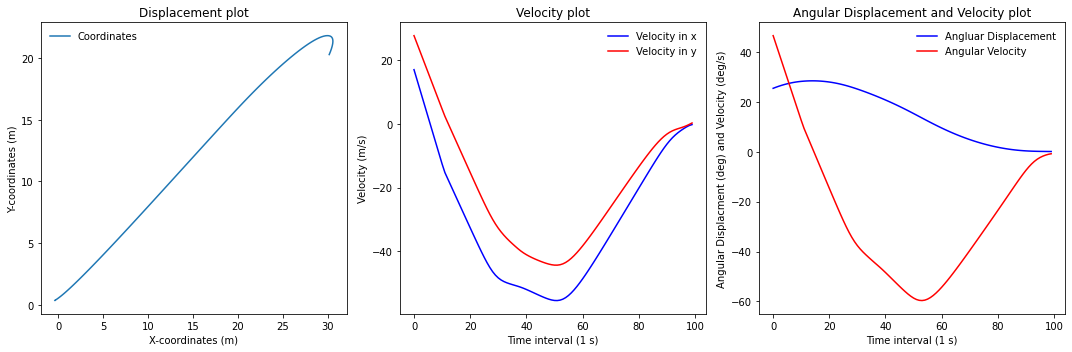

[41] loss: 0.853


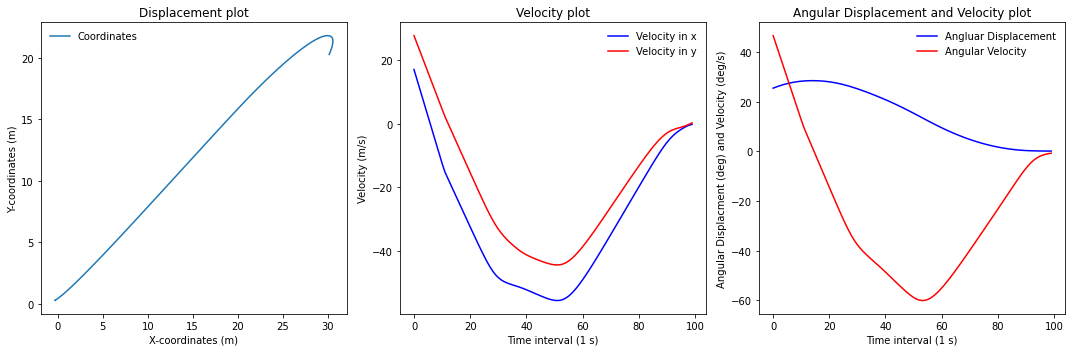

[42] loss: 0.716


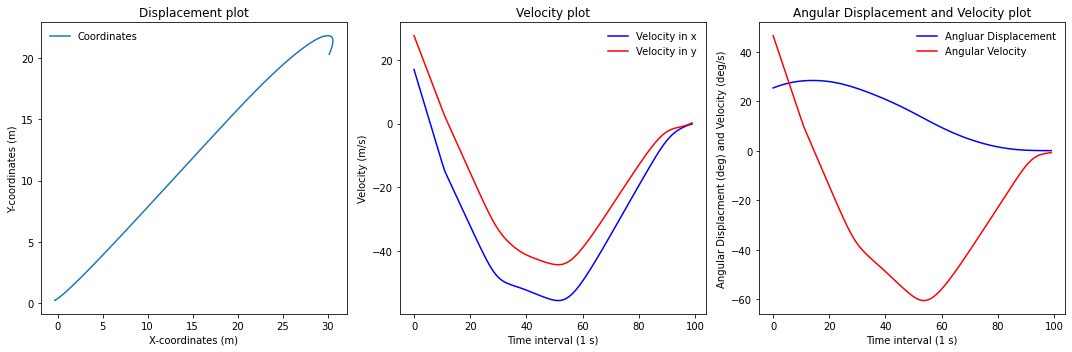

[43] loss: 0.581


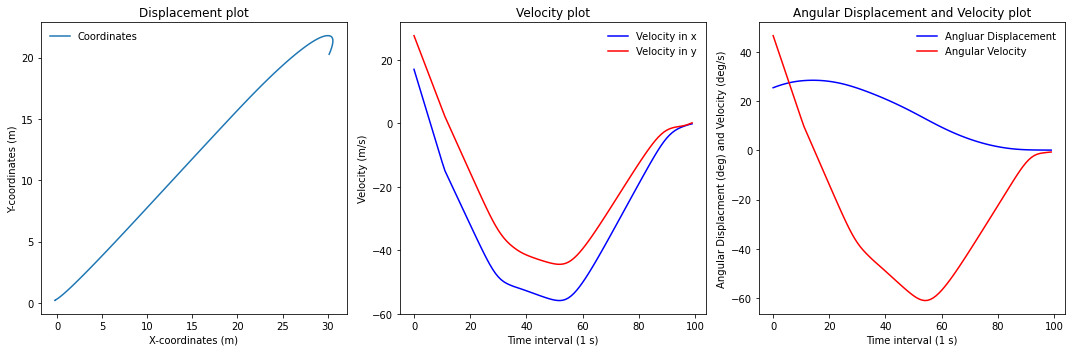

[44] loss: 0.460


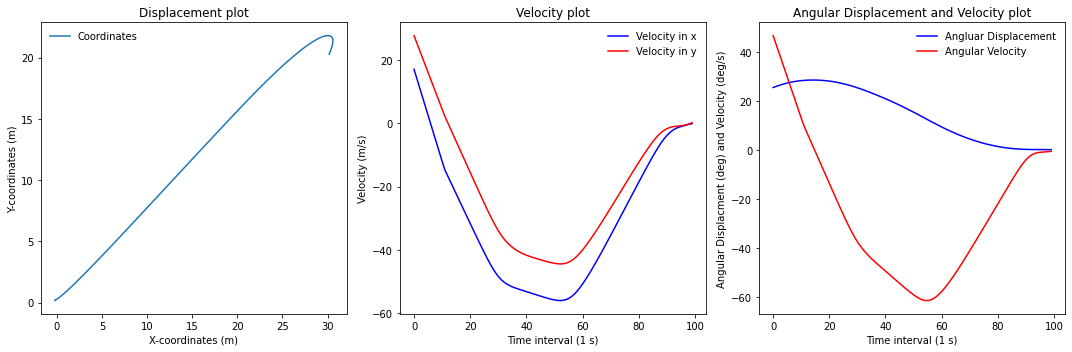

[45] loss: 0.362


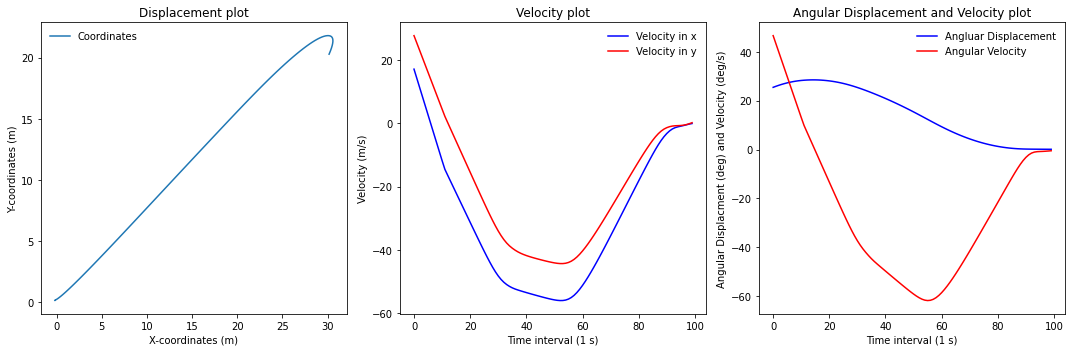

[46] loss: 0.284


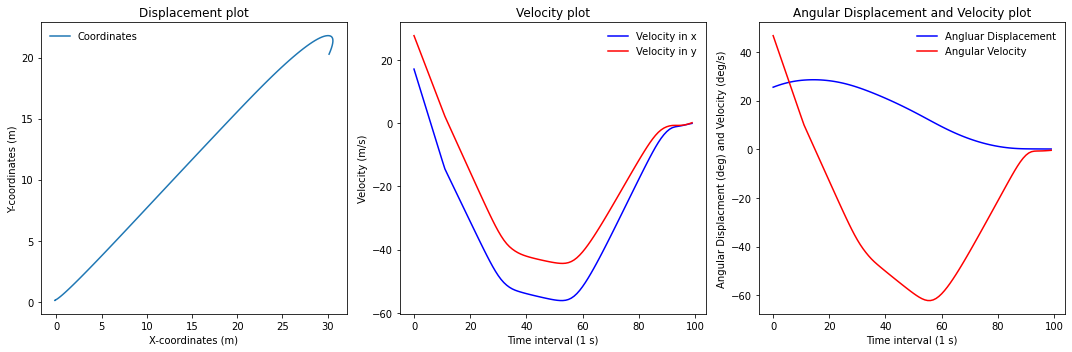

[47] loss: 0.220


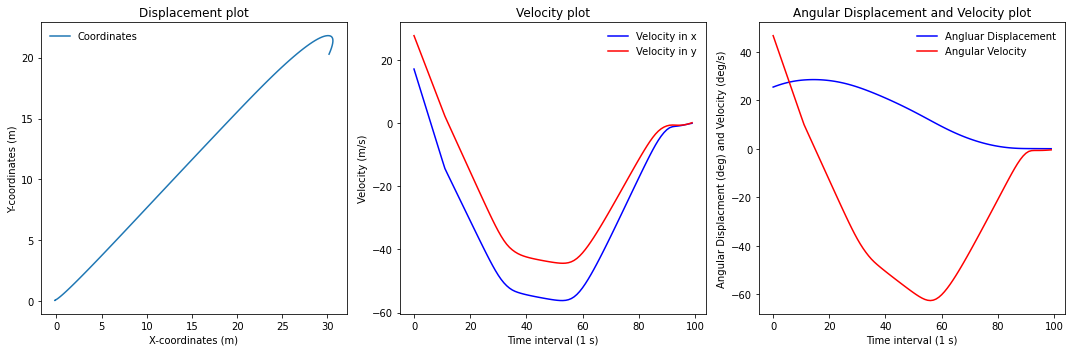

[48] loss: 0.164


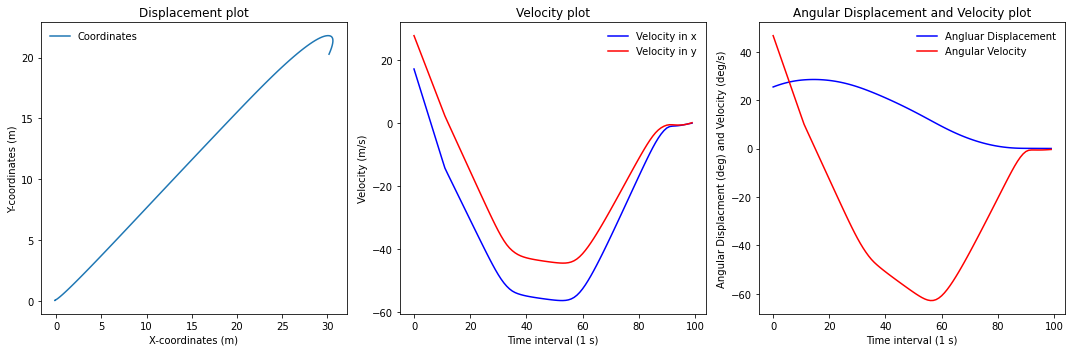

[49] loss: 0.118


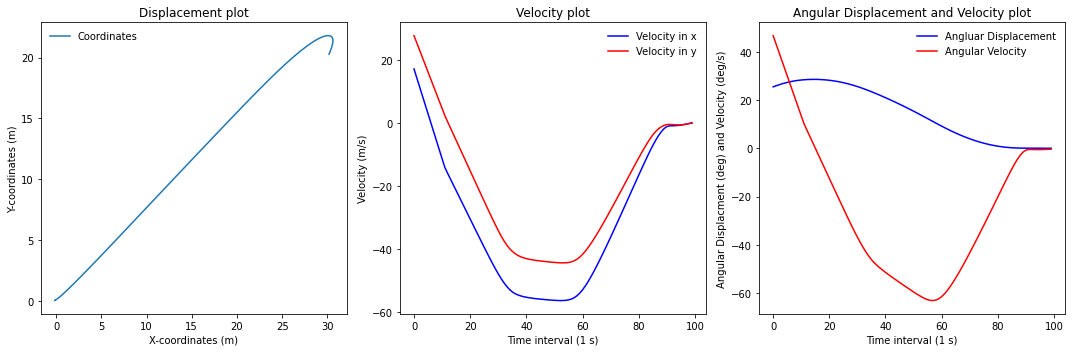

[50] loss: 0.083


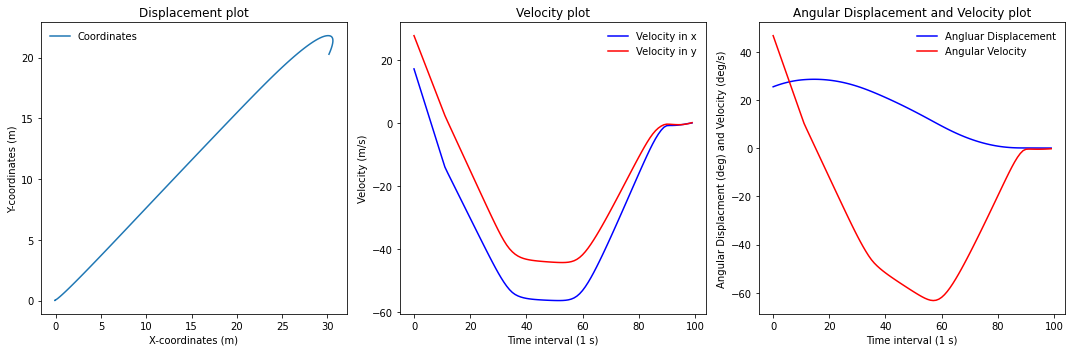

[51] loss: 0.058


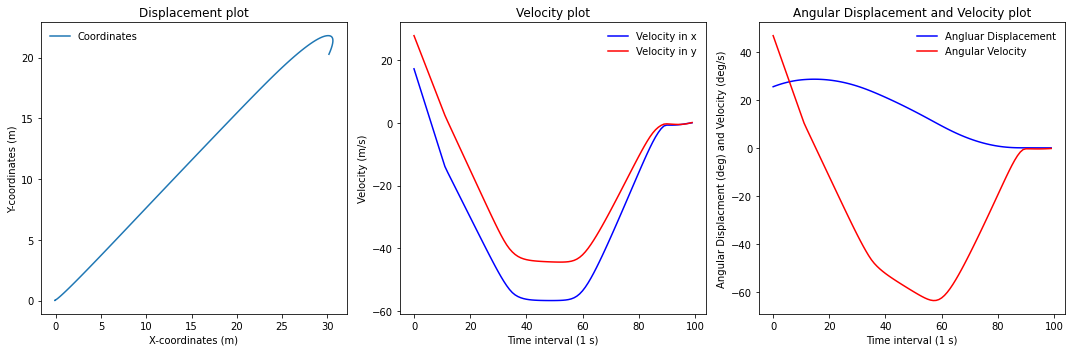

[52] loss: 0.039


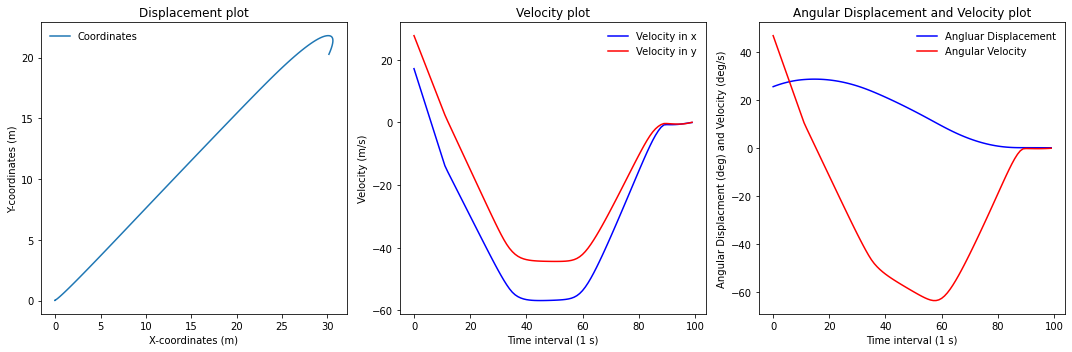

[53] loss: 0.027


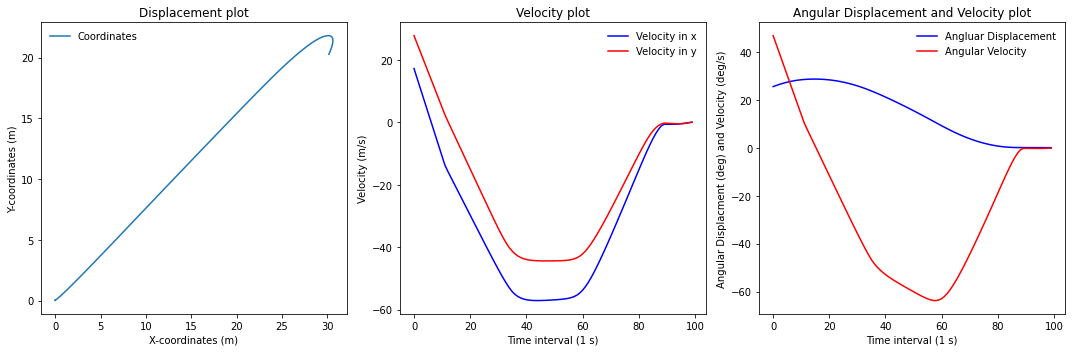

[54] loss: 0.018


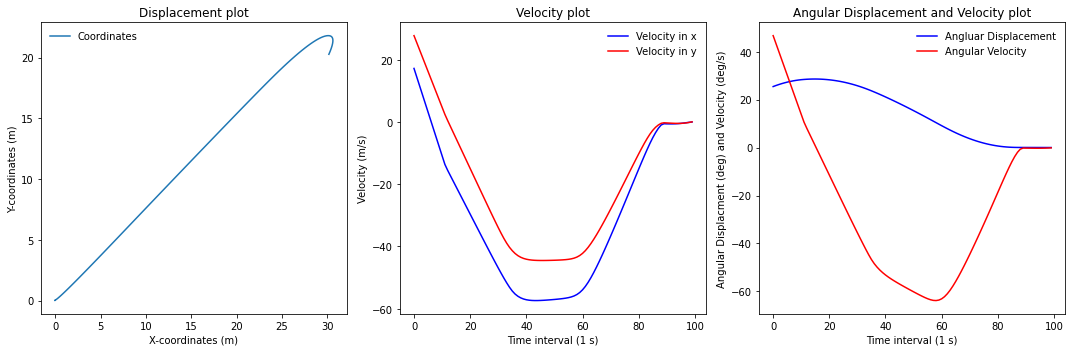

[55] loss: 0.013


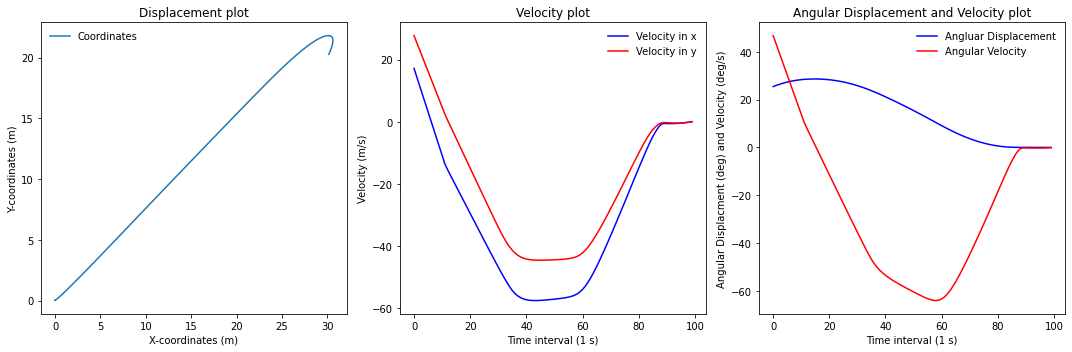

[56] loss: 0.009


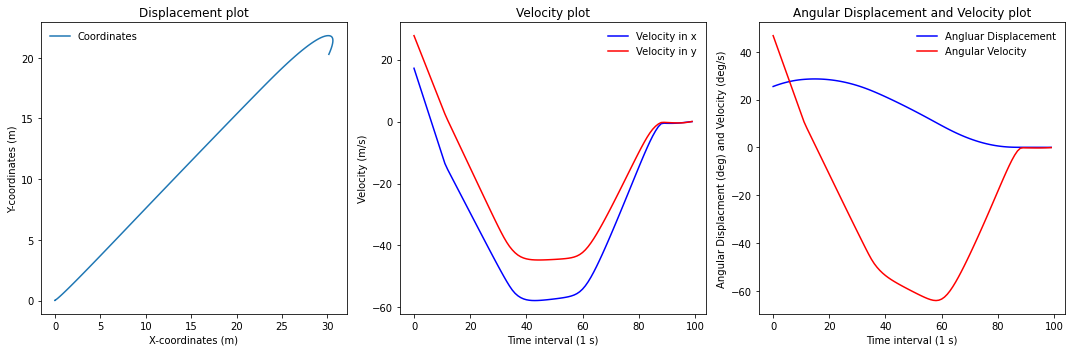

[57] loss: 0.007


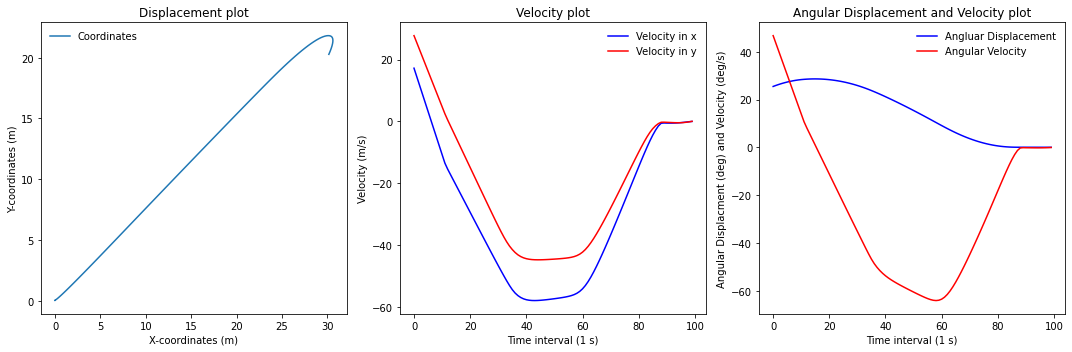

[58] loss: 0.005


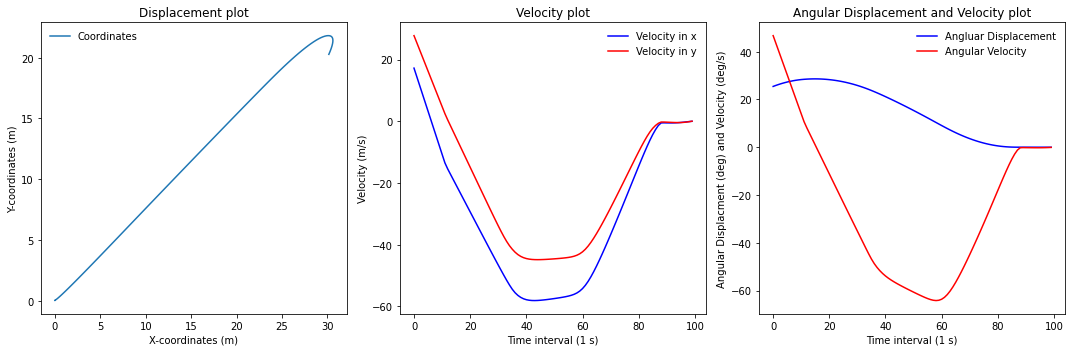

[59] loss: 0.004


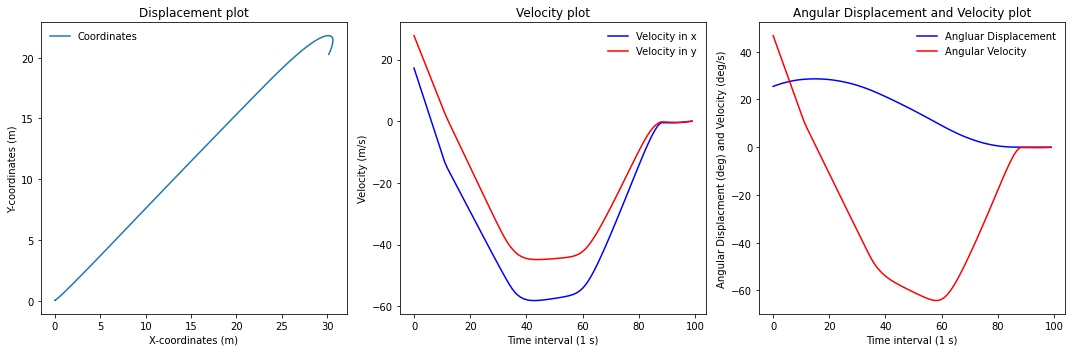

[60] loss: 0.003


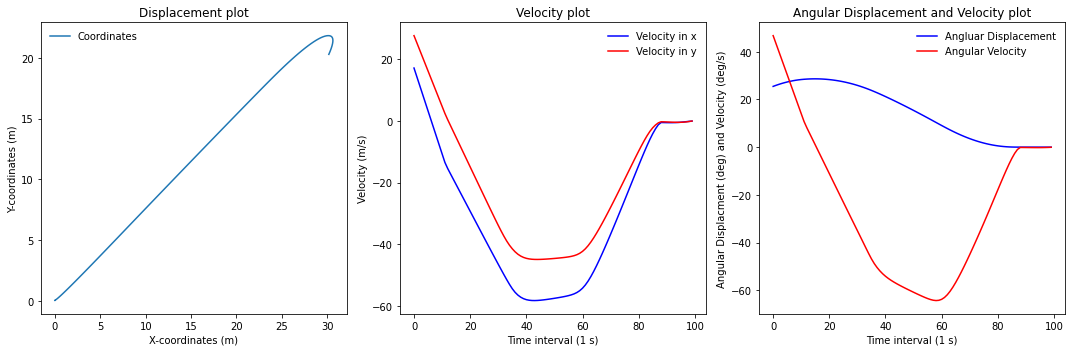

In [15]:
# Now it's time to run the code!

T = 100 # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 3 # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem